In [63]:
from sklearn import cluster
from sklearn.decomposition import PCA
from collections import Counter
import random
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import wordlexp as we
import importlib

# Intro
Wordle is interesting. People have their strategies.

People have propsed lists:

And some people have debate as to the best word

https://www.gamespot.com/articles/the-best-wordle-starting-word-has-been-figured-out-with-computer-science/1100-6500073/

As a bioinformatician, life and data - here's how I chose a set of even better starting words

# Evaluating which word is better

We need a system to 'rank' how good starting words are.
We'll do this by making a 'random_guesser' and evaluating how long it takes to guess the correct word, how often it fails given the initial starting word. The random guesser works by picking one word from the list of all possible, valid words remaining. So it's not RANDOM random, it knows what the valid words are and perfectly evaluates which ones are remaining.

Let's evaluate two words mentioned in the article:

The linguist's *irate* and the computer scientist's *later*

In [80]:
importlib.reload(we)
score_later = we.evaluate_first_word('later', samples=3,  n=500)
score_irate = we.evaluate_first_word('irate', samples=3, n=500)

In [81]:
scores = pd.DataFrame([score_later, score_irate], index=['later', 'irate'])
scores

,speed,loss
later,4.226006,10.0
irate,4.272285,10.6


irate:
    Wins in 4.28 guesses.
    Loses 11.92% of the time

later:
    Wins in 4.20 guesses.
    Loses 9.46% of the time
    
I need to do this a few times to a better estimate, but this is sufficient for now.

And we could just brute force this and get the scores for every word. but let's look for something better


# Letter Frequency

They chose these words based on the frequency of the letters. We can plot out each letter's frequency in the list of valid words and see the following.

bar plot

As expected, the most common letters are a mix of the vowels and consonants ABCD.

<AxesSubplot:xlabel='Letter', ylabel='Freq'>

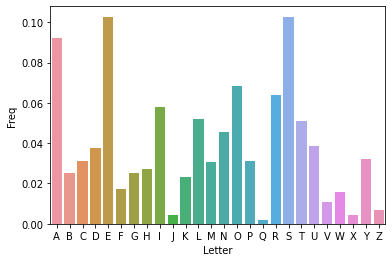

In [83]:
view = np.ravel(we.all_words[we.letter_cols].values)
counts = np.unique(view, return_counts=True)
frequencies = np.asarray(counts).T
data = pd.DataFrame(frequencies, columns=["Letter", "Count"])
data["Freq"] = data["Count"] / data["Count"].sum()
alphabet = [chr(_) for _ in range(ord('A'), ord('Z') + 1)]
sb.barplot(data=data, x="Letter", y="Freq", order=alphabet)
data.set_index('Letter', inplace=True)

Now we can go in and score all the words by their letter frequency.

In [94]:
def word_freq_sum(word):
    return sum([data.loc[_]["Freq"] for _ in word])
word_scores = we.all_words["word"].apply(word_freq_sum).to_frame("score")
word_scores["word"] = we.all_words["word"]
word_scores['uniq'] = we.all_words['unique']
word_scores['valid'] = we.all_words['valid']
word_scores.sort_values(["score"], ascending=False, inplace=True)
word_scores[(word_scores["uniq"] == 5) & (word_scores['valid'])].head()

,score,word,uniq,valid
1252,0.430358,AROSE,5,True
560,0.419889,ARISE,5,True
1668,0.419889,RAISE,5,True
915,0.412735,STARE,5,True
1658,0.407755,AISLE,5,True


In [95]:
scores.loc["AROSE"] = we.evaluate_first_word("AEROS", samples=3, n=500)
scores

,speed,loss
later,4.226006,10.000000
irate,4.272285,10.600000
inter,4.263323,11.400000
liner,4.343849,11.200000
alert,4.242685,8.933333
tails,4.151961,9.666667
trail,4.163780,9.600000
AEROS,4.295419,12.333333
AROSE,4.333333,13.133333


# Bioinformatics Something

But! This approach of letter frequency has a flawed assumption. It ignores that the letters used in words are not random. There's positional information e.g. N words end in X. We can look at the positional frequency by using a logo

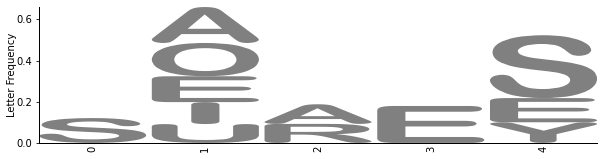

In [25]:
we.make_logo(we.all_words, min_freq=0.09)

This shows that there's positional information. If you're not convinced there's positional information, we can take the entire set of words, pool and shuffle all the letters, then remake a new set of 5 letter words. Each letter has the same frequency, but now the words are nonsene.

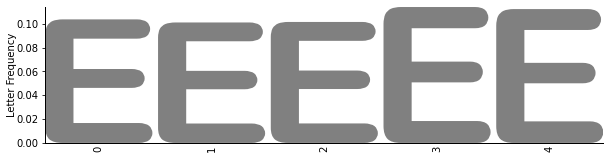

In [28]:
pooled_letters = list("".join(we.all_words[we.all_words["valid"]]["word"]))
# Shuffle the letters
random.shuffle(pooled_letters)
# Make new 5-letter words from the letters
shuf_words = []
for i in range(0, len(pooled_letters), 5):
    shuf_words.append("".join(pooled_letters[i:i+5]))
# Oranize - can ignore
shuf_words = pd.Series(shuf_words).to_frame('word')
for i in range(5):
    shuf_words[f'L-{i}'] = shuf_words['word'].apply(lambda x: str(x)[i].upper())
we.make_logo(shuf_words, min_freq=0.09)

We see that E, the most frequent letter, appears most frequently in each position.
So, clearly there's some structure here.

In [114]:
parts = []
for i in we.letter_cols:
    parts.append(we.all_words[i].value_counts() / len(we.all_words))
matrix = pd.concat(parts, axis=1)
def get_pos_score(word):
    score = 0
    for pos, let in enumerate(word):
        score += matrix.loc[let][f"L-{pos}"]
    return score / len(word)

pos_scores = we.all_words["word"].apply(get_pos_score).to_frame("score")
pos_scores["word"] = we.all_words["word"]
pos_scores['uniq'] = we.all_words['unique']
pos_scores['valid'] = we.all_words['valid']
pos_scores.sort_values(["score"], ascending=False, inplace=True)
pos_scores[(pos_scores["uniq"] == 5) & (pos_scores['valid'])].head()

,score,word,uniq,valid
1752,0.130558,TORUS,5,True
1159,0.128400,BONUS,5,True
1607,0.120136,SANER,5,True
2067,0.117129,BONEY,5,True
269,0.114786,FOCUS,5,True


In [113]:
scores.loc['TORUS'] = we.evaluate_first_word("TORUS", samples=3,n=500)
scores

,speed,loss
later,4.226006,10.000000
irate,4.272285,10.600000
inter,4.263323,11.400000
liner,4.343849,11.200000
alert,4.242685,8.933333
tails,4.151961,9.666667
trail,4.163780,9.600000
AEROS,4.295419,12.333333
AROSE,4.333333,13.133333
TORUS,4.221020,9.066667


# DiGram

<AxesSubplot:xlabel='index', ylabel='Freq'>

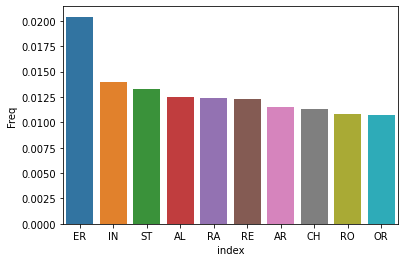

In [58]:
#A-Z in word at all - give them all neighbors
def pair_counter(word):
    c = Counter()
    for i in range(len(word) - 1):
        c[word[i:i+2]] += 1
    return c
parts = we.all_words[we.all_words['valid']]['word'].apply(pair_counter)
digram = pd.DataFrame(list(parts)).fillna(0)
summary = (digram.sum().sort_values(ascending=False) / digram.sum().sum()).to_frame('Freq')
sb.barplot(data=summary.head(10).reset_index(), y="Freq", x='index')

In [117]:
def pair_freq_score(word):
    scr = 0
    for i in range(0, len(word) - 1):
        scr += summary.loc[word[i:i+2]]
    return scr
subset = we.all_words['valid'] & (we.all_words['unique'] == 5)
candidates = we.all_words[subset][we.letter_cols].isin(list("ERINST")).sum(axis=1)
#candiates['letFreq'] = 
view = we.all_words.loc[candidates[candidates == 5].sort_values(ascending=False).index].copy()
view['di_score'] = view['word'].apply(pair_freq_score)
view.sort_values('di_score', inplace=True, ascending=False)
view.head(5)

,word,valid,L-0,L-1,L-2,L-3,L-4,unique,di_score
461,INTER,True,I,N,T,E,R,5,0.049460
315,INERT,True,I,N,E,R,T,5,0.045032
1297,STERN,True,S,T,E,R,N,5,0.045032
508,STEIN,True,S,T,E,I,N,5,0.038229
2054,RINSE,True,R,I,N,S,E,5,0.032505


# Score these 5 words - They're better, but there's gotta be more

In [82]:
for i in view.head(3)['word']:
    scores.loc[i.lower()] = we.evaluate_first_word(i, samples=3,n=500, plot=False)
scores.loc['tails'] = we.evaluate_first_word('tails', samples=3,n=500, plot=False)
scores.loc['trail'] = we.evaluate_first_word('trail', samples=3,n=500, plot=False)
scores

,speed,loss
later,4.226006,10.000000
irate,4.272285,10.600000
inter,4.263323,11.400000
liner,4.343849,11.200000
alert,4.242685,8.933333
tails,4.151961,9.666667
trail,4.163780,9.600000


In [129]:
def pca_analysis(data):    
    n_components = 5
    comp_header = ['pc%d' % (_+1) for _ in range(n_components)]
    x = PCA(n_components=n_components)
    principalComponents = x.fit_transform(data.values)
    principalDf = pd.DataFrame(data = principalComponents,
                               columns = comp_header)
    principalDf['word'] = we.all_words[we.all_words['valid']]['word']#header#
    print("Explained variance")
    print(x.explained_variance_ratio_)

    # Clustering
    clust = cluster.KMeans(3, random_state=2)
    clust.fit(principalDf[['pc1', 'pc2', 'pc3', 'pc4', 'pc5']])
    labels = pd.Series(clust.labels_, name="label", index=principalDf.index, dtype=str)
    principalDf['label'] = labels
    
    # Make the plot
    g = sb.PairGrid(data=principalDf, vars=comp_header, hue='label')
    g.map_offdiag(sb.scatterplot)#, alpha=0.2)
    g.map_diag(sb.histplot)
    plt.show()
    
    # Show the cluster logos
    for lab, d in principalDf.groupby(['label']):
        print('label', lab)
        view = we.all_words[we.all_words['word'].isin(d['word'])]
        display(we.letter_summary(view).head())
        display(view[(view['valid']) & (view['unique'] == 5)].sample(5))
        print(len(view['valid']), 'valid words')
        we.make_logo(view)
    

Explained variance
[0.10962003 0.08983152 0.08022298 0.07605137 0.0693664 ]


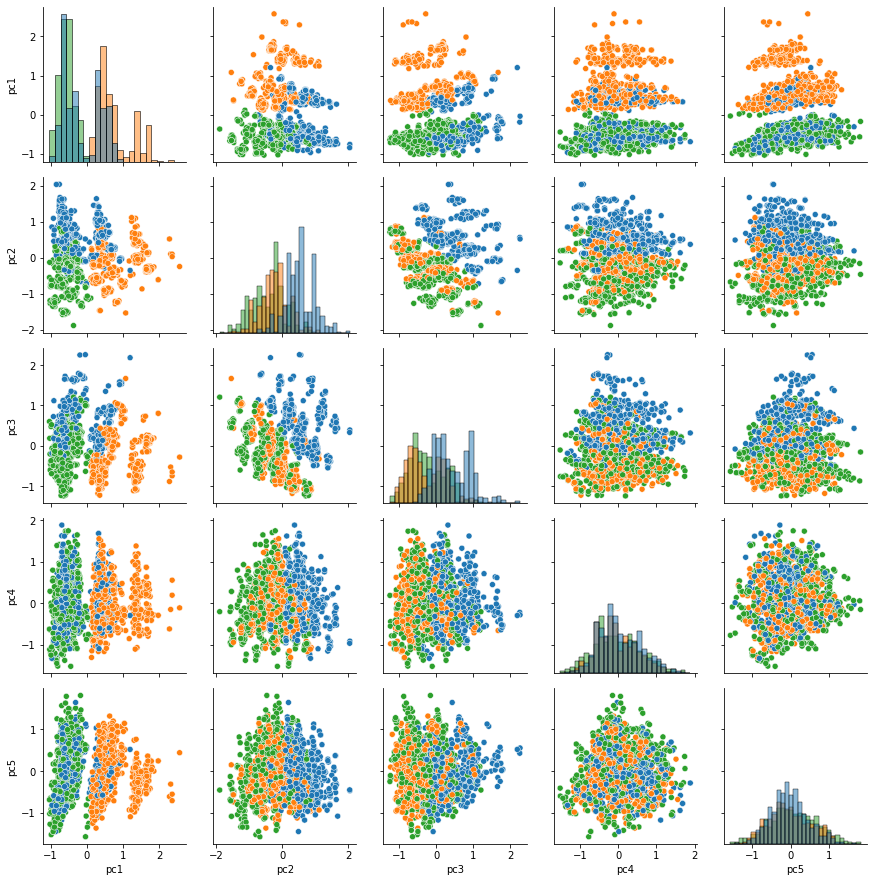

label 0


,count,freq
value,,
A,850,0.998825
E,344,0.404230
R,313,0.367803
L,276,0.324324
T,238,0.279671


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
2275,LOAMY,True,L,O,A,M,Y,5
984,EARTH,True,E,A,R,T,H,5
1231,SPACE,True,S,P,A,C,E,5
1686,CAIRN,True,C,A,I,R,N,5
1272,TRAMP,True,T,R,A,M,P,5


851 valid words


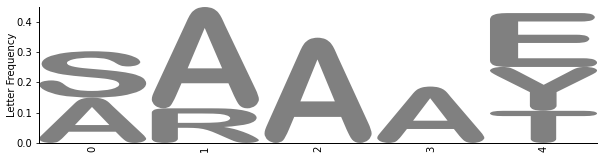

label 1


,count,freq
value,,
O,375,0.494071
I,307,0.404480
U,265,0.349144
T,244,0.321476
R,225,0.296443


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
2099,TRUCK,True,T,R,U,C,K,5
993,HUSKY,True,H,U,S,K,Y,5
386,PINTO,True,P,I,N,T,O,5
1453,VYING,True,V,Y,I,N,G,5
1091,LURID,True,L,U,R,I,D,5


759 valid words


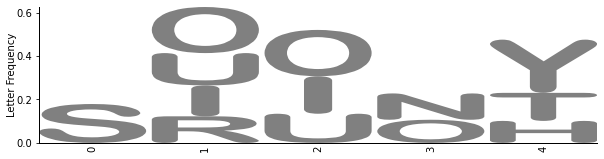

label 2


,count,freq
value,,
E,705,1.000000
R,299,0.424113
I,210,0.297872
O,186,0.263830
T,185,0.262411


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
1648,BEGIN,True,B,E,G,I,N,5
1314,LEMUR,True,L,E,M,U,R,5
196,REBUS,True,R,E,B,U,S,5
723,HOUSE,True,H,O,U,S,E,5
2208,RELIC,True,R,E,L,I,C,5


705 valid words


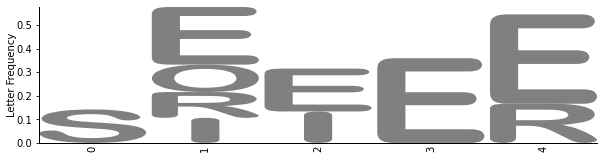

In [130]:
#A-Z in word at all - give them all neighbors
header = []
parts = []
for i in range(ord('A'), ord('Z') + 1):
    letter = chr(i)
    header.append(letter)
    has_letter = we.all_words[we.all_words['valid']][we.letter_cols].isin([letter]).sum(axis=1)
    #has_letter['letter'] = letter
    parts.append(has_letter)
data = pd.concat(parts, axis=1)
data.columns = header
#A-Z in a position - give them all edges

#Then I hunt for neighborhoods? Or some kind of way to separate pieces.
data.head()

pca_analysis(data)

# DiGram PCA

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_70230/742961976.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pca_analysis(digram[we.all_words['unique'] == 5])


Explained variance
[0.02178451 0.01943871 0.01794423 0.01715306 0.01654317]


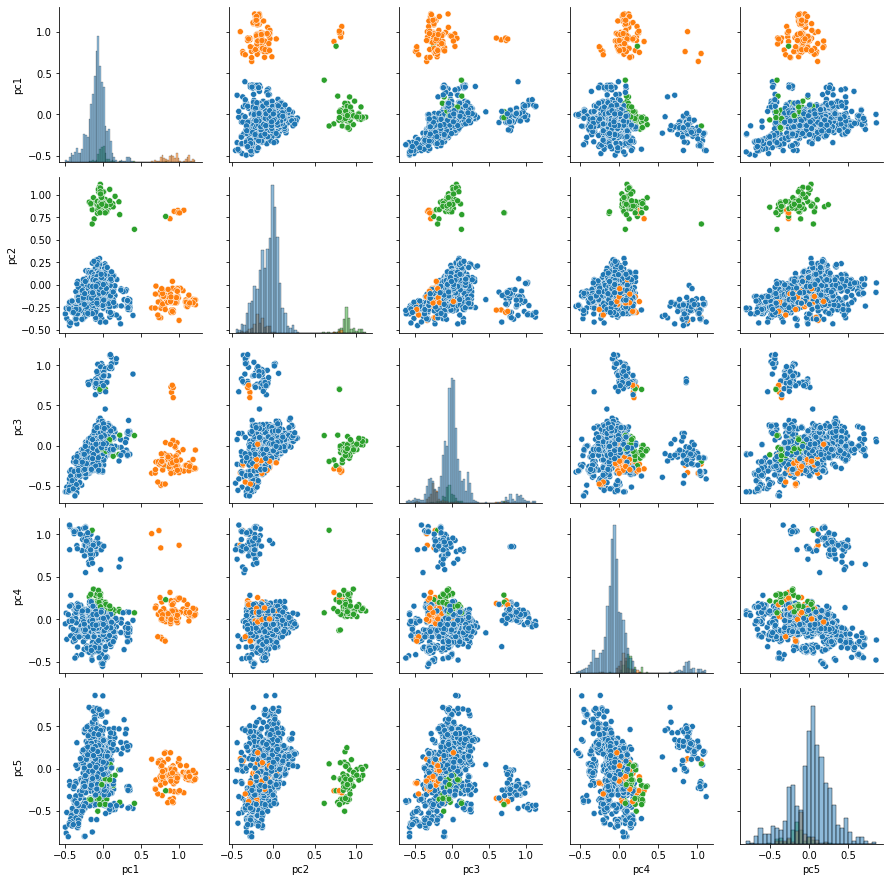

label 0


,count,freq
value,,
E,634,0.470326
A,528,0.391691
R,493,0.365727
O,399,0.295994
L,390,0.289318


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
889,VISTA,True,V,I,S,T,A,5
1297,STERN,True,S,T,E,R,N,5
1061,SNIDE,True,S,N,I,D,E,5
265,MONTH,True,M,O,N,T,H,5
1005,SPORE,True,S,P,O,R,E,5


1348 valid words


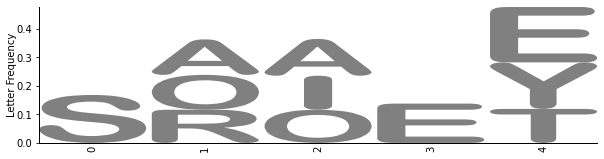

label 1


,count,freq
value,,
E,46,0.407080
R,43,0.380531
A,41,0.362832
O,32,0.283186
L,32,0.283186


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
1183,PRANK,True,P,R,A,N,K,5
1052,BUSHY,True,B,U,S,H,Y,5
357,PHASE,True,P,H,A,S,E,5
1538,HEAVY,True,H,E,A,V,Y,5
1451,OPTIC,True,O,P,T,I,C,5


113 valid words


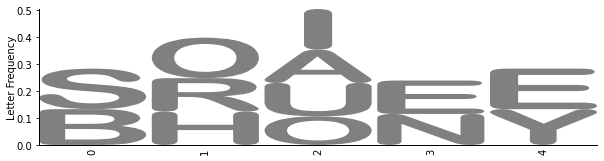

label 2


,count,freq
value,,
E,44,0.419048
A,41,0.390476
N,35,0.333333
I,34,0.323810
T,33,0.314286


,word,valid,L-0,L-1,L-2,L-3,L-4,unique
1548,SCENT,True,S,C,E,N,T,5
47,SPIKE,True,S,P,I,K,E,5
618,FINAL,True,F,I,N,A,L,5
1345,FALSE,True,F,A,L,S,E,5
280,PURGE,True,P,U,R,G,E,5


105 valid words


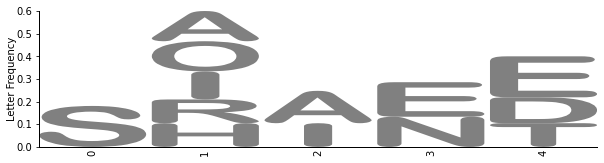

In [144]:
pca_analysis(digram[we.all_words['unique'] == 5])

In [141]:
x = we.all_words[we.letter_cols].isin(list("STER")).sum(axis=1)
we.all_words[(x == x.max()) & (we.all_words['unique'] == 5)]

,word,valid,L-0,L-1,L-2,L-3,L-4,unique



# PCA
We can start to find the structure of words by doing a PCA and then K-Means clustering.

Pair Grid

And if we separate the letters, we get the logos

So we're just pulling out the vowels.

# Best words

Just take the frequency of the digrams and then choose the top - whatever.
Then we'll pick words that have the most of these letters and choose.
Then we'll do the evaluate_first_word on IDK.. I might search down to find the best one from the top whatever.